In [1]:
import os
import ta
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from pandas.core.frame import DataFrame
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
train_set = pd.read_csv("train.csv") 
test_set = pd.read_csv("test.csv")

In [4]:
train_set.head(2)

,Date,Open,High,Low,Volume,Close
0,14-08-2015,57.484790,58.398406,57.342469,171718000,58.237720
1,17-08-2015,58.274453,59.013611,58.026536,163538800,58.788651


In [5]:
test_set.head(2)

,Date,Open,High,Low,Volume,Close
0,30-07-2021,293.328006,297.222166,292.788806,70382000,NaN
1,02-08-2021,297.282094,298.460321,295.065414,62880000,NaN


In [6]:
def dataset_maker(df: DataFrame):
    out_df = df
    out_df.index = pd.to_datetime(df.Date, format="%d-%m-%Y")
    return out_df.drop("Date", axis=1)

In [7]:
train = dataset_maker(train_set)
test = dataset_maker(test_set)

In [8]:
train.head(5)

,Open,High,Low,Volume,Close
Date,,,,,
2015-08-14,57.484790,58.398406,57.342469,171718000,58.237720
2015-08-17,58.274453,59.013611,58.026536,163538800,58.788651
2015-08-18,58.453501,58.917197,58.260678,138242800,58.485638
2015-08-19,58.301997,58.494820,57.650069,193146000,57.801575
2015-08-20,57.374601,57.498558,56.249794,274006400,56.718082


In [9]:
test.head(5)

,Open,High,Low,Volume,Close
Date,,,,,
2021-07-30,293.328006,297.222166,292.788806,70382000,NaN
2021-08-02,297.282094,298.460321,295.065414,62880000,NaN
2021-08-03,296.183715,300.637034,294.925590,64786600,NaN
2021-08-04,299.099384,300.137807,297.122335,56368300,NaN
2021-08-05,298.520228,300.237657,296.902657,46397700,NaN


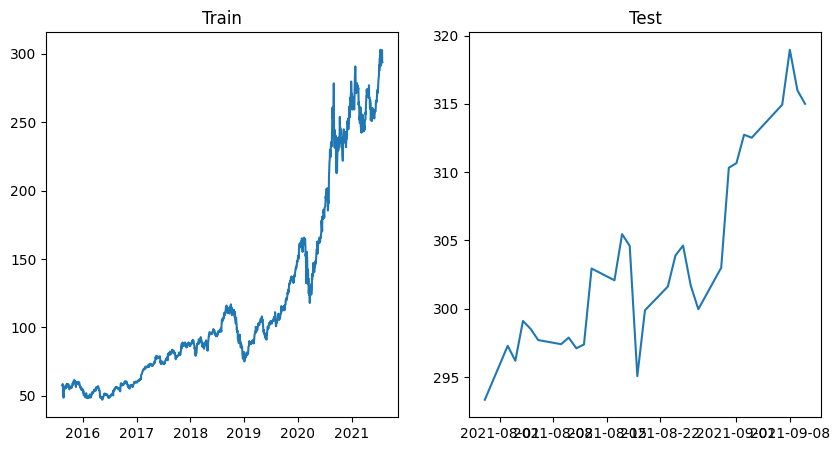

In [10]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(train.Open)
ax1.title.set_text("Train")
ax2.plot(test.Open)
ax2.title.set_text("Test")

In [11]:
def Pivot(dataframe: DataFrame, Order=3, **kwargs) -> DataFrame:
    df = dataframe.copy()
    local_highs = argrelextrema(df.High.values, np.greater_equal, order=Order)[0]  # order=3
    local_lows = argrelextrema(df.Low.values, np.less_equal, order=Order)[0]
    HighPivots = [1 if i in df.iloc[local_highs].index else 0 for i in df.index]
    LowPivots = [1 if i in df.iloc[local_lows].index else 0 for i in df.index]
    df.insert(0, "HighPivots", HighPivots, True)
    df.insert(0, "LowPivots", LowPivots, True)
    return df

In [12]:
p_train = Pivot(train)
p_train.head(5)

,LowPivots,HighPivots,Open,High,Low,Volume,Close
Date,,,,,,,
2015-08-14,1,0,57.484790,58.398406,57.342469,171718000,58.237720
2015-08-17,0,1,58.274453,59.013611,58.026536,163538800,58.788651
2015-08-18,0,0,58.453501,58.917197,58.260678,138242800,58.485638
2015-08-19,0,0,58.301997,58.494820,57.650069,193146000,57.801575
2015-08-20,0,0,57.374601,57.498558,56.249794,274006400,56.718082


In [13]:
p_test = Pivot(test)
p_test.head(5)

,LowPivots,HighPivots,Open,High,Low,Volume,Close
Date,,,,,,,
2021-07-30,1,0,293.328006,297.222166,292.788806,70382000,NaN
2021-08-02,0,0,297.282094,298.460321,295.065414,62880000,NaN
2021-08-03,0,1,296.183715,300.637034,294.925590,64786600,NaN
2021-08-04,0,0,299.099384,300.137807,297.122335,56368300,NaN
2021-08-05,0,0,298.520228,300.237657,296.902657,46397700,NaN


In [14]:
def Data_augmentation(df: DataFrame):
    data = df.copy()
    data.insert(0, "ohlc4", (df.Open + df.High + df.Low + df.Close) / 4)
    
    ema = ta.trend.EMAIndicator(df.Close).ema_indicator()
    data.insert(0, "ema", ema, True)
    
    ia = ta.trend.ichimoku_a(df.High, df.Low)
    data.insert(0, "ia", ia, True)
    
    ib = ta.trend.ichimoku_b(df.High, df.Low)
    data.insert(0, "ib", ib, True)
    
    ibl = ta.trend.ichimoku_base_line(df.High, df.Low)
    data.insert(0, "ibl", ibl, True)
    
    icl = ta.trend.ichimoku_conversion_line(df.High, df.Low)
    data.insert(0, "icl", icl, True)
    
    macd = ta.trend.macd(df.Close, )
    data.insert(0, "macd", macd, True)
    
    rsi = ta.momentum.RSIIndicator(df.Close, ).rsi()
    data.insert(0, "rsi", rsi, True)
    
    
    
    return data

In [15]:
aug_train = Data_augmentation(p_train)
aug_train

,rsi,macd,icl,ibl,ib,ia,ema,ohlc4,LowPivots,HighPivots,Open,High,Low,Volume,Close
Date,,,,,,,,,,,,,,,
2015-08-14,NaN,NaN,NaN,NaN,57.870437,NaN,NaN,57.865846,1,0,57.484790,58.398406,57.342469,171718000,58.237720
2015-08-17,NaN,NaN,NaN,NaN,58.178040,NaN,NaN,58.525812,0,1,58.274453,59.013611,58.026536,163538800,58.788651
2015-08-18,NaN,NaN,NaN,NaN,58.178040,NaN,NaN,58.529253,0,0,58.453501,58.917197,58.260678,138242800,58.485638
2015-08-19,NaN,NaN,NaN,NaN,58.178040,NaN,NaN,58.062115,0,0,58.301997,58.494820,57.650069,193146000,57.801575
2015-08-20,NaN,NaN,NaN,NaN,57.631702,NaN,NaN,56.960259,0,0,57.374601,57.498558,56.249794,274006400,56.718082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-23,67.190692,7.868762,296.233665,283.792311,276.842719,290.012988,293.687876,300.432374,0,0,299.658540,301.995035,298.400415,71447400,301.675507
2021-07-26,67.816619,7.898955,296.233665,283.792311,276.842719,290.012988,294.867391,301.950109,0,1,301.096392,304.211720,299.958083,72434100,302.534241
2021-07-27,61.313202,7.478934,296.233665,283.792311,277.451804,290.012988,295.298521,299.883186,0,0,302.793811,302.973565,295.664509,104818600,298.100861


In [16]:
dropna_aug_train = aug_train.dropna(how="any")
dropna_aug_train.head(3)

,rsi,macd,icl,ibl,ib,ia,ema,ohlc4,LowPivots,HighPivots,Open,High,Low,Volume,Close
Date,,,,,,,,,,,,,,,
2015-09-21,54.489890,0.200188,57.030278,53.125599,53.125599,55.077938,57.139411,57.557101,0,0,57.186374,57.966853,57.181785,200888000,57.893394
2015-09-22,50.209236,0.173211,57.060119,53.125599,53.125599,55.092859,57.129146,57.048653,0,0,57.053243,57.420528,56.658414,201384800,57.062428
2015-09-23,52.262029,0.183794,57.487087,53.077392,53.125599,55.282239,57.176566,57.334434,0,0,57.168008,57.668433,57.016506,143026800,57.484791


In [17]:
def scale(df: DataFrame):
    scaler = StandardScaler()
    df_to_scale = df.drop("Close", axis=1)
    np_scaled = scaler.fit_transform(df_to_scale)
    np_scaled_to_df = pd.DataFrame(np_scaled, index=df_to_scale.index, 
                                   columns=df_to_scale.columns)
    output = np_scaled_to_df.join(df.Close)
    
    return output

In [18]:
scaled_df = scale(dropna_aug_train)
scaled_df.head(3)

,rsi,macd,icl,ibl,ib,ia,ema,ohlc4,LowPivots,HighPivots,Open,High,Low,Volume,Close
Date,,,,,,,,,,,,,,,
2015-09-21,-0.171972,-0.303080,-0.886620,-0.935924,-0.922829,-0.911728,-0.886994,-0.882333,-0.319987,-0.317406,-0.886875,-0.882170,-0.882024,1.128833,57.893394
2015-09-22,-0.489500,-0.312351,-0.886188,-0.935924,-0.922829,-0.911510,-0.887143,-0.889631,-0.319987,-0.317406,-0.888785,-0.889910,-0.889639,1.136991,57.062428
2015-09-23,-0.337229,-0.308714,-0.880004,-0.936631,-0.922829,-0.908748,-0.886452,-0.885529,-0.319987,-0.317406,-0.887139,-0.886398,-0.884428,0.178743,57.484791


In [19]:
def to_windowframe(df:DataFrame, window_size=3):
    l = len(df)
    output_columns = [f"Pday{i}" for i in reversed(range(1, window_size + 1))]
    output_columns.append("Target")
    output_indexs = [i for i in range(0, l - window_size)]
    output_df = pd.DataFrame(index=output_indexs, columns=output_columns)
    i = window_size
    while i < l:
#         print("i:", i)
        for col, j in enumerate(range(i - window_size, i + 1)):
            if col == window_size:
                output_df.iloc[i - window_size, col] = df.iloc[j].Close
            else:
                output_df.iloc[i - window_size, col] = df.iloc[j].to_numpy().astype('float32')
#             print("j:", j)
#             print("col:", col)
#             print("output_df.iloc[i - window_size, j]:", output_df.iloc[i - window_size, col])
#             print("df.iloc[j].to_numpy():", df.iloc[j].to_numpy())
#             print(output_df)
            
        i += 1
#     output_df = np.stack([np.stack(row) for row in output_df])
    return output_df

In [20]:
main_train = to_windowframe(scaled_df, 5)
main_train.head(3)

,Pday5,Pday4,Pday3,Pday2,Pday1,Target
0,"[-0.17197174, -0.30308023, -0.88662, -0.935924...","[-0.4894995, -0.31235054, -0.8861878, -0.93592...","[-0.33722866, -0.30871388, -0.8800036, -0.9366...","[-0.22471067, -0.29802653, -0.8796378, -0.9384...","[-0.28209355, -0.29414475, -0.88030285, -0.938...",56.621681
1,"[-0.4894995, -0.31235054, -0.8861878, -0.93592...","[-0.33722866, -0.30871388, -0.8800036, -0.9366...","[-0.22471067, -0.29802653, -0.8796378, -0.9384...","[-0.28209355, -0.29414475, -0.88030285, -0.938...","[-0.7072676, -0.32055715, -0.88030285, -0.9384...",55.069901
2,"[-0.33722866, -0.30871388, -0.8800036, -0.9366...","[-0.22471067, -0.29802653, -0.8796378, -0.9384...","[-0.28209355, -0.29414475, -0.88030285, -0.938...","[-0.7072676, -0.32055715, -0.88030285, -0.9384...","[-1.2254733, -0.38437364, -0.8936355, -0.93848...",55.639194


In [21]:
def featurs_target_spliter(df: DataFrame, to_numpy=True):
    x = df.iloc[:, :-1]
    y = df.Target
    if to_numpy:
        x = x.to_numpy()
        x = np.stack([np.stack(row).astype('float32') for row in x]).astype('float32')
        y = y.to_numpy().astype('float32')
    return x, y

In [22]:
x, y = featurs_target_spliter(main_train)
x, y

(array([[[-1.7197174e-01, -3.0308023e-01, -8.8661999e-01, ...,
          -8.8202369e-01,  1.1288331e+00,  5.7893394e+01],
         [-4.8949951e-01, -3.1235054e-01, -8.8618779e-01, ...,
          -8.8963866e-01,  1.1369907e+00,  5.7062428e+01],
         [-3.3722866e-01, -3.0871388e-01, -8.8000357e-01, ...,
          -8.8442850e-01,  1.7874277e-01,  5.7484791e+01],
         [-2.2471067e-01, -2.9802653e-01, -8.7963778e-01, ...,
          -8.9064085e-01,  1.1286689e+00,  5.7796978e+01],
         [-2.8209355e-01, -2.9414475e-01, -8.8030285e-01, ...,
          -8.7961918e-01,  1.5183128e+00,  5.7663830e+01]],
 
        [[-4.8949951e-01, -3.1235054e-01, -8.8618779e-01, ...,
          -8.8963866e-01,  1.1369907e+00,  5.7062428e+01],
         [-3.3722866e-01, -3.0871388e-01, -8.8000357e-01, ...,
          -8.8442850e-01,  1.7874277e-01,  5.7484791e+01],
         [-2.2471067e-01, -2.9802653e-01, -8.7963778e-01, ...,
          -8.9064085e-01,  1.1286689e+00,  5.7796978e+01],
         [-2.8209355e

In [23]:
x.shape

(1470, 5, 15)

In [24]:
x_train, y_train = x[:1200], y[:1200]
x_cv, y_cv = x[1200:1350], y[1200:1350]
x_test, y_test = x[1350:], y[1350:]

In [25]:
data_train = scaled_df.index[5:1200+5]
data_cv = scaled_df.index[5+1200:1350+5]
data_test = scaled_df.index[5+1350:]

In [26]:
x_train.shape, x_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape

((1200, 5, 15), (1200, 5, 15), (150, 5, 15), (150,), (120, 5, 15), (120,))

In [27]:
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(5000),
# #     tf.keras.layers.Dense(256, activation="relu"), 
# #     tf.keras.layers.Dense(128, activation="relu"), 
#     tf.keras.layers.Dense(32, activation="relu"), 
#     tf.keras.layers.Dense(1, activation="linear")
# ])

In [28]:
def model_create():
    inputs = tf.keras.Input(shape=(5, 15))
#     x = tf.keras.layers.LSTM(500, activation="relu", return_sequences=True)(inputs)
#     x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.LSTM(200, activation="relu")(inputs)
#     x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
#     x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    output = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inputs, outputs=[output])
    return model

In [29]:
mymodel = model_create()

In [30]:
mymodel(x_train[:3])

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[6.7485137],
       [6.8207664],
       [6.6464615]], dtype=float32)>

In [31]:
mymodel.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.1), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [32]:
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * 0.95

In [33]:
callbacks = list()
# callbacks.append(tf.keras.callbacks.ModelCheckpoint(
#     "C:/Users/asus/Ipy/MyCodes/Others/Work Project/model/", save_best_only=True))
callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler, 1))

In [34]:
mymodel.fit(x_train, y_train, epochs=100, 
          validation_data=(x_cv, y_cv), 
          shuffle=False, callbacks=callbacks, batch_size=32)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/100
38/38 [==============================] - 3s 27ms/step - loss: 154706657280.0000 - root_mean_squared_error: 393327.6562 - val_loss: 120.7477 - val_root_mean_squared_error: 10.9885 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/100
38/38 [==============================] - 1s 20ms/step - loss: 161.0054 - root_mean_squared_error: 12.6888 - val_loss: 2098.9573 - val_root_mean_squared_error: 45.8144 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/100
38/38 [==============================] - 1s 19ms/step - loss: 488.8937 - root_mean_squared_error: 22.1109 - val_loss: 166.1782 - val_root_mean_squared_error: 12.8910 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/100
38/38 [==============================] - 1s 19ms/step - loss: 213.3862 - root_mean_square

38/38 [==============================] - 1s 15ms/step - loss: 65.9857 - root_mean_squared_error: 8.1232 - val_loss: 726.8621 - val_root_mean_squared_error: 26.9604 - lr: 0.1000

Epoch 32: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 32/100
38/38 [==============================] - 1s 15ms/step - loss: 62.4768 - root_mean_squared_error: 7.9042 - val_loss: 764.0274 - val_root_mean_squared_error: 27.6410 - lr: 0.1000

Epoch 33: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 33/100
38/38 [==============================] - 1s 14ms/step - loss: 72.1647 - root_mean_squared_error: 8.4950 - val_loss: 894.5225 - val_root_mean_squared_error: 29.9086 - lr: 0.1000

Epoch 34: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 34/100
38/38 [==============================] - 1s 15ms/step - loss: 70.8318 - root_mean_squared_error: 8.4162 - val_loss: 925.5226 - val_root_mean_squared_error: 30.4224 - lr: 0.1000

Epoch 35: Learn


Epoch 62: LearningRateScheduler setting learning rate to 0.05403600092977285.
Epoch 62/100
38/38 [==============================] - 1s 16ms/step - loss: 26.9235 - root_mean_squared_error: 5.1888 - val_loss: 189.9792 - val_root_mean_squared_error: 13.7833 - lr: 0.0540

Epoch 63: LearningRateScheduler setting learning rate to 0.05133420247584581.
Epoch 63/100
38/38 [==============================] - 1s 16ms/step - loss: 26.4966 - root_mean_squared_error: 5.1475 - val_loss: 187.4052 - val_root_mean_squared_error: 13.6896 - lr: 0.0513

Epoch 64: LearningRateScheduler setting learning rate to 0.048767492175102234.
Epoch 64/100
38/38 [==============================] - 1s 16ms/step - loss: 26.6838 - root_mean_squared_error: 5.1656 - val_loss: 182.4875 - val_root_mean_squared_error: 13.5088 - lr: 0.0488

Epoch 65: LearningRateScheduler setting learning rate to 0.04632911756634712.
Epoch 65/100
38/38 [==============================] - 1s 16ms/step - loss: 27.1805 - root_mean_squared_error: 5.2

38/38 [==============================] - 1s 16ms/step - loss: 44.9109 - root_mean_squared_error: 6.7016 - val_loss: 203.1113 - val_root_mean_squared_error: 14.2517 - lr: 0.0116

Epoch 93: LearningRateScheduler setting learning rate to 0.011018309090286492.
Epoch 93/100
38/38 [==============================] - 1s 16ms/step - loss: 39.5742 - root_mean_squared_error: 6.2908 - val_loss: 313.2320 - val_root_mean_squared_error: 17.6984 - lr: 0.0110

Epoch 94: LearningRateScheduler setting learning rate to 0.010467393370345234.
Epoch 94/100
38/38 [==============================] - 1s 15ms/step - loss: 27.7898 - root_mean_squared_error: 5.2716 - val_loss: 268.5072 - val_root_mean_squared_error: 16.3862 - lr: 0.0105

Epoch 95: LearningRateScheduler setting learning rate to 0.00994402365759015.
Epoch 95/100
38/38 [==============================] - 1s 15ms/step - loss: 26.5325 - root_mean_squared_error: 5.1510 - val_loss: 274.6516 - val_root_mean_squared_error: 16.5726 - lr: 0.0099

Epoch 96: Lea

In [35]:
mymodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 15)]           0         
                                                                 
 lstm (LSTM)                 (None, 200)               172800    
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 187,777
Trainable params: 187,777
Non-trainable params: 0
_________________________________________________________________


In [36]:
mymodel.predict(x_train[:3])

array([[59.449337],
       [57.637806],
       [59.799763]], dtype=float32)

In [37]:
mymodel.layers

In [38]:
train_preds = mymodel.predict(x_train)
cv_preds = mymodel.predict(x_cv)
test_pres = mymodel.predict(x_test)

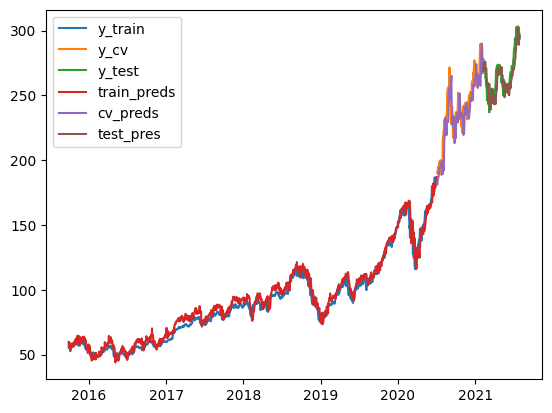

In [39]:
plt.plot(data_train, y_train)
plt.plot(data_cv, y_cv)
plt.plot(data_test, y_test)
plt.plot(data_train, train_preds)
plt.plot(data_cv, cv_preds)
plt.plot(data_test, test_pres)
plt.legend(["y_train", 
           "y_cv", 
           "y_test", 
           "train_preds", 
           "cv_preds", 
           "test_pres", ])

In [40]:
TT = pd.concat([p_train, p_test])
TT.iloc[1495:1505]

,LowPivots,HighPivots,Open,High,Low,Volume,Close
Date,,,,,,,
2021-07-23,0,0,299.658540,301.995035,298.400415,71447400,301.675507
2021-07-26,0,1,301.096392,304.211720,299.958083,72434100,302.534241
2021-07-27,0,0,302.793811,302.973565,295.664509,104818600,298.100861
2021-07-28,1,0,294.186727,298.500271,289.653510,118931200,294.526215
2021-07-29,0,0,293.947087,297.661523,293.727415,56699500,295.844238
2021-07-30,1,0,293.328006,297.222166,292.788806,70382000,NaN
2021-08-02,0,0,297.282094,298.460321,295.065414,62880000,NaN
2021-08-03,0,1,296.183715,300.637034,294.925590,64786600,NaN
2021-08-04,0,0,299.099384,300.137807,297.122335,56368300,NaN


In [41]:
def return_test(model, window_size=3):
    i = 0
    temp_df = pd.DataFrame()
    for index, (time, row) in enumerate(TT.iterrows()):
        if row.isna().any():
            i = index
            temp_df = TT[index - 70: index + 1]
            break
    temp_df_aug = Data_augmentation(temp_df)
    temp_df_s = scale(temp_df_aug)
    temp_df_s_resize = temp_df_s.iloc[-(window_size + 1):]
    temp_df_w = to_windowframe(temp_df_s_resize, window_size)
    temp_df_x, _ = featurs_target_spliter(temp_df_w)
    y_hat = model.predict(temp_df_x)[0, 0]
    return y_hat, i
#     TT.iloc[i].Close = y_hat

In [42]:
y, i = return_test(mymodel, 5)
y, i

(302.03876, 1500)

In [43]:
for j in range(30):
    y, i = return_test(mymodel, 5)
    TT.loc[TT.iloc[i].name, "Close"] = y

In [44]:
TT.tail(30)

,LowPivots,HighPivots,Open,High,Low,Volume,Close
Date,,,,,,,
2021-07-30,1,0,293.328006,297.222166,292.788806,70382000,302.038757
2021-08-02,0,0,297.282094,298.460321,295.065414,62880000,305.740234
2021-08-03,0,1,296.183715,300.637034,294.925590,64786600,300.510712
2021-08-04,0,0,299.099384,300.137807,297.122335,56368300,300.339569
2021-08-05,0,0,298.520228,300.237657,296.902657,46397700,299.996429
2021-08-06,0,0,297.700012,299.220001,296.260010,54067400,306.022858
2021-08-09,0,0,297.399994,298.399994,296.040008,48908700,310.464874
2021-08-10,1,0,297.880005,300.420013,295.600006,69023100,302.844940
2021-08-11,0,0,297.100006,298.440002,296.059998,48493500,305.474487


In [45]:
TT[1500:].index

DatetimeIndex(['2021-07-30', '2021-08-02', '2021-08-03', '2021-08-04',
               '2021-08-05', '2021-08-06', '2021-08-09', '2021-08-10',
               '2021-08-11', '2021-08-12', '2021-08-13', '2021-08-16',
               '2021-08-17', '2021-08-18', '2021-08-19', '2021-08-20',
               '2021-08-23', '2021-08-24', '2021-08-25', '2021-08-26',
               '2021-08-27', '2021-08-30', '2021-08-31', '2021-09-01',
               '2021-09-02', '2021-09-03', '2021-09-07', '2021-09-08',
               '2021-09-09', '2021-09-10'],
              dtype='datetime64[ns]', name='Date', freq=None)

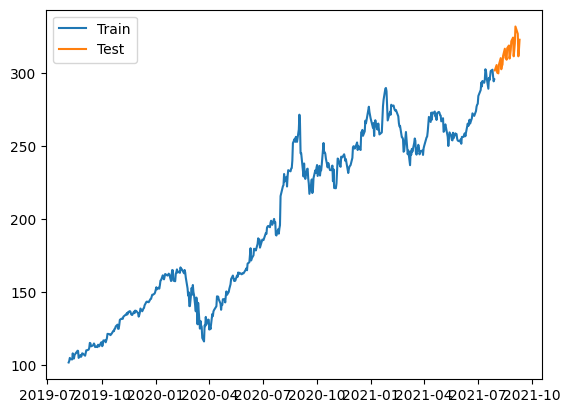

In [46]:
plt.plot(TT[1000:1500].index, TT[1000:1500].Close)
plt.plot(TT[1500:].index, TT[1500:].Close)

plt.legend(["Train", "Test"])

TypeError: yticks(): Parameter 'labels' can't be set without setting 'ticks'

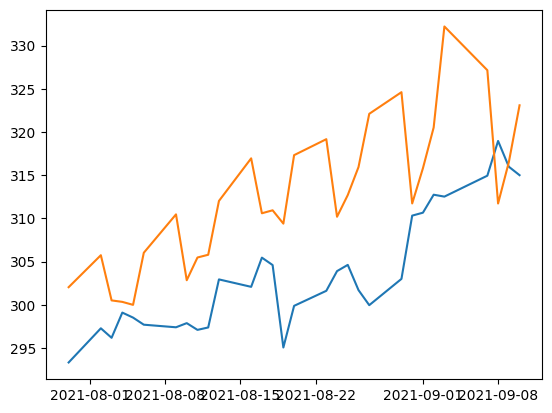

In [49]:
plt.plot(TT[1500:].index, TT[1500:].Open)
plt.plot(TT[1500:].index, TT[1500:].Close)
plt.yticks(labels=[i for i in range(30)])

plt.legend(["Open", "Close"])